#                        King County Home Price Prediction

In [1]:
#import packages to be used for data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import zscore
sns.set()
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [2]:
#read in dataset into pandas
df = pd.read_csv('housesalesprediction/kc_house_data.csv')

In [3]:
#inspect how many rows and columns are in datasest
df.shape

(21613, 21)

In [4]:
#view first couple rows to make sure columns and rows are labeled 
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [5]:
#take a look at the different data types of the values in the columns
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
id               21613 non-null int64
date             21613 non-null object
price            21613 non-null float64
bedrooms         21613 non-null int64
bathrooms        21613 non-null float64
sqft_living      21613 non-null int64
sqft_lot         21613 non-null int64
floors           21613 non-null float64
waterfront       21613 non-null int64
view             21613 non-null int64
condition        21613 non-null int64
grade            21613 non-null int64
sqft_above       21613 non-null int64
sqft_basement    21613 non-null int64
yr_built         21613 non-null int64
yr_renovated     21613 non-null int64
zipcode          21613 non-null int64
lat              21613 non-null float64
long             21613 non-null float64
sqft_living15    21613 non-null int64
sqft_lot15       21613 non-null int64
dtypes: float64(5), int64(15), object(1)
memory usage: 3.5+ MB


In [6]:
#drop id column as it is not a useful variable in house prediction
df.drop(['id'], axis=1, inplace=True)

In [7]:
#take a look at the names of all the columns
print(df.columns)
columns_list = df.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [8]:
#check if row labels correspond to index labels on this data set
df.iloc[[0,1500]]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20141013T000000,221900.0,3,1.0,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1500,20150312T000000,249000.0,3,1.5,1700,8247,1.0,0,0,3,7,1010,690,1970,0,98031,47.4216,-122.174,1440,8400


In [9]:
#check to see if there are any missing values in dataset
df.isnull().sum()
df.isnull().sum().sum()

0

In [10]:
#take a look at zip code column and sort out unique values to see if data is sufficient for all of king county predictions
all_zip_codes = df['zipcode']
zip_codes = df['zipcode'].unique()
np.sort(zip_codes)
len(zip_codes)

70

### With 108 zip codes in the total King County area and 70 provided in this dataset, we can conclude that this dataset is a good representation of the King County area.

In [11]:
#pick a couple of features and see if there are any trends to know which features to use in exploratory data analysis
subset = df[['price','bedrooms','bathrooms','sqft_living']]
subset.head()

,price,bedrooms,bathrooms,sqft_living
0,221900.0,3,1.00,1180
1,538000.0,3,2.25,2570
2,180000.0,2,1.00,770
3,604000.0,4,3.00,1960
4,510000.0,3,2.00,1680


In [12]:
#filter the highest grade according to king county.gov/assesor buiding grade and compare against price
df.loc[df['grade'] == 13, ['grade', 'price']]

,grade,price
4411,13,5570000.0
4811,13,2479000.0
5451,13,1780000.0
6041,13,2385000.0
7035,13,3800000.0
7252,13,7700000.0
7907,13,3200000.0
9254,13,6885000.0
10373,13,2983000.0
13411,13,2415000.0


### There is definitely a very high correlation between building grade and price. One home with highest building grade is listed as 7.7 million dollars.

In [13]:
#subset the highest buiding grade and highest building condition together (in accordance to king county.gov/assessor)
df.loc[(df['grade'] == 13) & (df['condition'] > 3), ['grade', 'condition', 'price']]

,grade,condition,price
7035,13,4,3800000.0
7252,13,4,7700000.0


### This shows that there are not too many homes with both highest building grade and highest condition.

In [14]:
# take a look at correlations of price vs different features to see which one is showing the highest correlation
df.corr()['price'].sort_values(ascending=False)

price            1.000000
sqft_living      0.702035
grade            0.667434
sqft_above       0.605567
sqft_living15    0.585379
bathrooms        0.525138
view             0.397293
sqft_basement    0.323816
bedrooms         0.308350
lat              0.307003
waterfront       0.266369
floors           0.256794
yr_renovated     0.126434
sqft_lot         0.089661
sqft_lot15       0.082447
yr_built         0.054012
condition        0.036362
long             0.021626
zipcode         -0.053203
Name: price, dtype: float64

### So, square footage, building grade and number of bathrooms tops the price correlation list. This matches the findings from the correlation heatmap which also shows that sqftliving, grade, sqftabove, sqftliving15 and bathrooms are the most highly correlated with price.  The correlation table also shows us how the top 5 features are so much more correlated than all the rest of the features with price. 

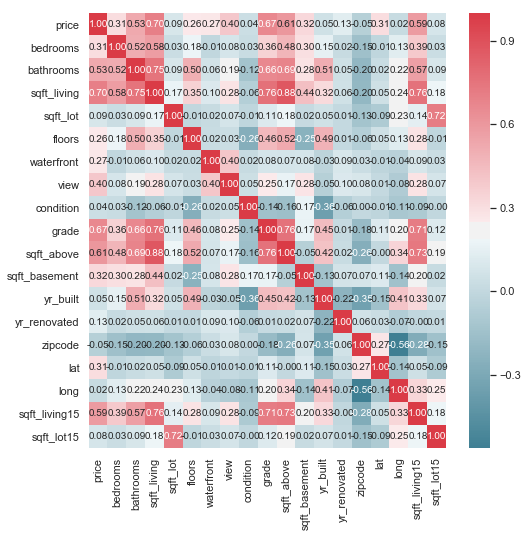

In [15]:
#create a correlation heatmap to see if there are trends between different features
corr_plot = df.corr()
fig, ax = plt.subplots(figsize = (8,8))
colormap=sns.diverging_palette(220,10, as_cmap=True)
_ = sns.heatmap(corr_plot,cmap=colormap,annot=True,fmt=".2f", xticklabels=corr_plot.columns, yticklabels=corr_plot.columns)
plt.show()

### The correlation heat map found some interesting additional trends. One interesting trend was the high correlation between grade and sqft_living.  This could be due to newly built,up to code homes, being built larger(https://www.nytimes.com/2016/06/04/upshot/houses-keep-getting-bigger-even-as-families-get-smaller.html). Another high correlation occured on the heatmap between number of bathrooms and sqft_living. This one makes sense since larger homes may have more bathrooms. Finally, an interesting but baffling strong negative correlation occured on the heatmap between floors and building condition implying that a higher number of floors is correlated with poor building condition.  In accordance to, www.info.kingcounty.gov, a poor building condition implies worn out, major repairs of painting, roofing, plumbing, or heating and other functional inadequacies.  Thus, the explanation for this correlation could be as simple as the more number of floors, the more repairs required since the more things to repair, for example, a stairwell(https://www.doityourself.com/stry/the-extra-costs-of-2-story-homes).  

(array([1.0000e+00, 3.0000e+00, 2.9000e+01, 2.4200e+02, 2.0380e+03,
        1.5049e+04, 2.6150e+03, 1.1340e+03, 3.9900e+02, 1.0300e+02]),
 array([ 1. ,  2.2,  3.4,  4.6,  5.8,  7. ,  8.2,  9.4, 10.6, 11.8, 13. ]),
 <a list of 10 Patch objects>)

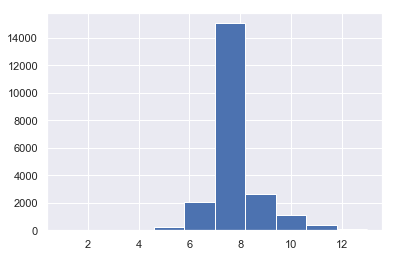

In [16]:
#since the correlation list showed grade has a high correlation with price,look at building grade distribution on histogram
plt.hist(df['grade'])

In [17]:
#take a look at stats for building grade
building_grade = df[['grade']]
mean_building_grade = np.mean(building_grade)
print('mean building ', mean_building_grade)

mean building  grade    7.656873
dtype: float64


### In our correlation stats, building grade was one of the highest correlation features with price and the building grade histogram above indicates that the majority of King County real estate falls around a 7.5 building grade.  This is an interesting finding since a building grade of 6 barely meets King County code, and the mean building grade of 7.5 is not too far above that.  Building grade, according to info.kingcounty.gov, is defined as the overall building construction, architectural design, and adherence to building codes.  

In [18]:
#take a look at stats for number of floors
no_of_floors = df[['floors']]
mean_no_floors = np.mean(no_of_floors)
print('mean no of ', mean_no_floors)

mean no of  floors    1.494309
dtype: float64


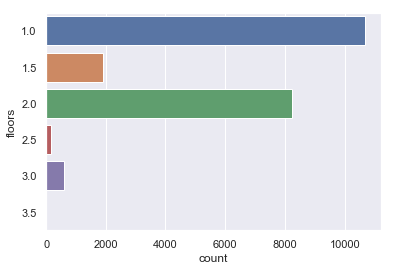

In [19]:
#due to finding negative correlation between number of floors and building condition, do countplot of the number of floors
sns.countplot(y=df['floors'])

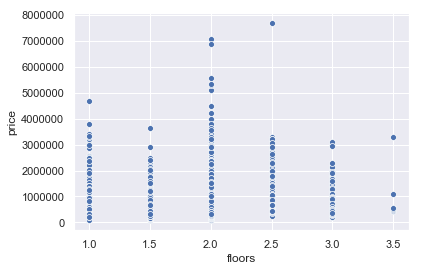

In [20]:
#take a look at scatterplot for floors
sns.scatterplot(x = 'floors',y = 'price', data = df)
plt.show()

### The heatmap showed a negative correlation between number of floors and building condition and according to the count plot above, the majority of homes in King County have one floor.  This is an interesting finding as it may not apply to all counties in Washington(https://magazine.realtor/daily-news/2016/08/08/one-vs-two-story-homes-which-dominates).  In fact, according to the aforementioned article, 31% of pacific state homes have one bedroom.  The reason for this discrepancy in King County, could be the county's building codes or the high cost of construction in King County, https://www.boardandvellum.com/blog/cost-of-construction-in-seattle/.  The other interesting finding is that floors does not appear to have a direct correlation with price.  In fact, according to the scatterplot, one floor can be the same price as multiple floors.  

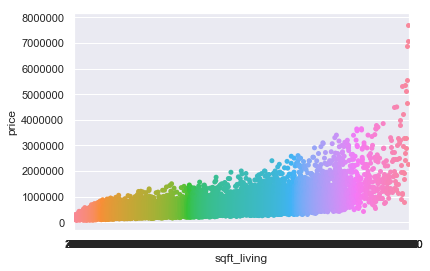

In [21]:
#take a look at another highly correlated feature, sqft_living, with home price utilizing a beeswarm plot
_ = sns.swarmplot(x='sqft_living', y='price', data=df)

### The beeswarm plot shows a strong correlation between square foot living area and home price, which is certainly what we would expect based on earlier correlation stats and heatmap.

In [22]:
#calculate the mean and median square foot living area
print('mean square footage is:', np.mean(df['sqft_living']))
sqft_med = np.sort(df['sqft_living'])
sqft_median = sqft_med[10806]
print("median square foot living area:", sqft_median)

mean square footage is: 2079.8997362698374
median square foot living area: 1910


{'whiskers': [<matplotlib.lines.Line2D at 0x28713b967f0>,
 'caps': [<matplotlib.lines.Line2D at 0x28713b96ef0>,
 'boxes': [<matplotlib.lines.Line2D at 0x28713b963c8>],
 'medians': [<matplotlib.lines.Line2D at 0x28713b91630>],
 'fliers': [<matplotlib.lines.Line2D at 0x28713b91d30>],
 'means': [<matplotlib.lines.Line2D at 0x28713b919b0>]}

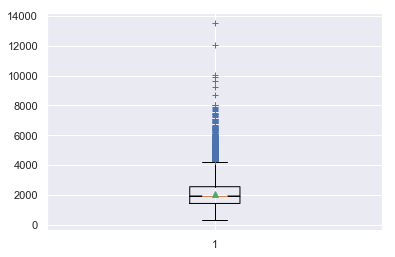

In [23]:
#take a look at median square foot living area on a box and whisker plot.
plt.boxplot(df['sqft_living'],1, showmeans = True, sym = 'b+')

{'whiskers': [<matplotlib.lines.Line2D at 0x2871713d400>,
 'caps': [<matplotlib.lines.Line2D at 0x2871713db00>,
 'boxes': [<matplotlib.lines.Line2D at 0x28717157fd0>],
 'medians': [<matplotlib.lines.Line2D at 0x2871713df98>],
 'fliers': [],
 'means': [<matplotlib.lines.Line2D at 0x287171585c0>]}

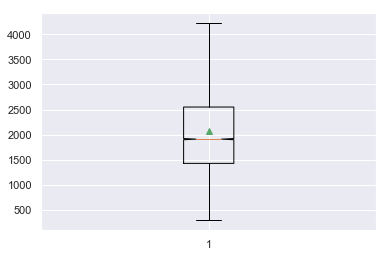

In [24]:
#compare that to the box and whisker plot without the outliers
plt.boxplot(df['sqft_living'],1, showmeans = True, sym = '')

### Since the boxplot median without outliers looks similar to that with outliers, we can conclude that the data so far appears well distributed.  The box and whisker plot also shows that the median square foot living area of 1,910 aligns closely with the mean square foot living area of 2,079.

In [25]:
#take a look at the basement feature to see how it affects home price
home_w_basemt = df['sqft_basement'] > 0
print("the no of homes with a basement:", home_w_basemt.sum())
home_wo_basemt = df['sqft_basement'] == 0
print("the no of homes without a basement:", home_wo_basemt.sum())
print("mean home w/ basemt price:", np.mean(df[home_w_basemt]['price']))
print("mean home w/o basemt price:", np.mean(df[home_wo_basemt]['price']))
med1_bsmt = np.sort(df[home_w_basemt]['price'])
print("median home w/ basemt price:", med1_bsmt[4243])
med2_bsmt = np.sort(df[home_wo_basemt]['price'])
print("median home w/o basemt price:", med2_bsmt[6562])

the no of homes with a basement: 8487
the no of homes without a basement: 13126
mean home w/ basemt price: 622373.5638034642
mean home w/o basemt price: 486884.0905073899
median home w/ basemt price: 515000.0
median home w/o basemt price: 411500.0


### Separating out homes with and without a basement came across an interesting discovery: there are almost double the homes in King County without a basement as there are with a basement.  According to kingcounty.gov,  this may be due to the constant rain in the winter causing a less stable soil composition. https://kingcounty.gov/~/media/depts/dnrp/solid-waste/ecoconsumer/documents/SeattleTimes_2013-07-26.ashx?la=en

## Violin plots displaying Median home price with and without a basement.

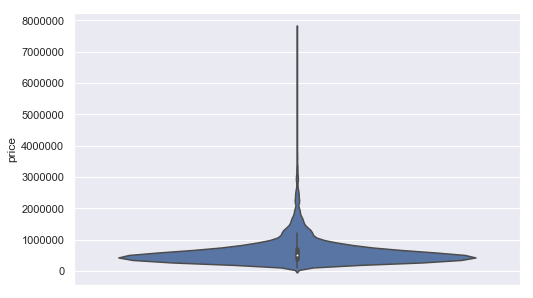

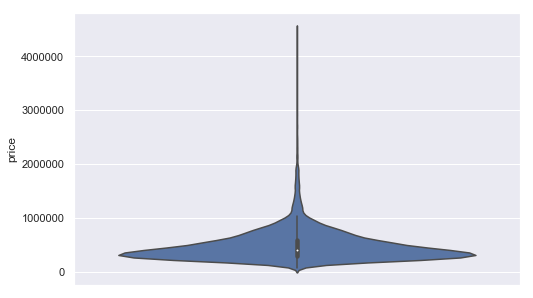

In [26]:
#create violin plots for median home price with and without a basement
from matplotlib import pyplot 
import seaborn
fig, ax = pyplot.subplots(figsize=(8,5))
sns.violinplot(ax=ax, y = df[home_w_basemt]['price'])
fig, ax = pyplot.subplots(figsize=(8,5))
sns.violinplot(ax=ax, y = df[home_wo_basemt]['price'])

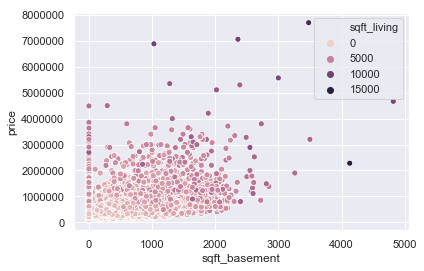

In [27]:
#plot out relationship between price, sqft_living and sqft_basment
sns.scatterplot(x = 'sqft_basement', y = 'price', data = df, hue = 'sqft_living')
plt.show()

### The violin plot on the top is the median home price with a basement and the violin plot on the bottom is the median home price without a basement.  The median home price without a basement, 411,500 dollars, is definitely much lower in price than that with a basement, 515,000 dollars. However, according to the scatterplot above, sqft_basement has a low correlation with price so what we do not know is if there are other factors at play.  One factor could be, exactly what the scatter plot is showing, that homes with a basement may also be homes that are larger in size. What we also know by the violin plot, is that the number of homes without a basement, 13,126, greatly out-number the number of homes with a basement, 8,487.   Finally, the median home price with a basement, 515,000 dollars, is not aligning as close with the mean home price with a basement, 622,374 dollars, and this could be due to the higher priced homes skewing the mean.  We will investigate this more closely by computing the mean vs median home price.

In [28]:
#compute percentiles for the prices of homes which will also give the median home price
home_mean = np.mean(df['price'])
print('mean home price is:', home_mean)
percentiles = np.array([2.5, 25, 50, 75, 97.5])
prices_homes = df[['price']]
homes_percent = np.percentile(prices_homes,percentiles)
print("percentiles for homes at 2.5%, 25%, 50%, 75% and, 97.5% is:", homes_percent)

mean home price is: 540088.1417665294
percentiles for homes at 2.5%, 25%, 50%, 75% and, 97.5% is: [ 185000.  321950.  450000.  645000. 1485000.]


In [29]:
#determine the median of the dataset(indices start at index 0)
all_home_prices = df['price']
all_sorted_prices = np.sort(all_home_prices)
print(len(all_sorted_prices)/2)
home_med = all_sorted_prices[10806]
print('median home price is:', home_med)

10806.5
median home price is: 450000.0


{'whiskers': [<matplotlib.lines.Line2D at 0x287171e9d68>,
 'caps': [<matplotlib.lines.Line2D at 0x287171ee748>,
 'boxes': [<matplotlib.lines.Line2D at 0x287171e9be0>],
 'medians': [<matplotlib.lines.Line2D at 0x287171eee48>],
 'fliers': [<matplotlib.lines.Line2D at 0x2871723d588>],
 'means': [<matplotlib.lines.Line2D at 0x287171eef60>]}

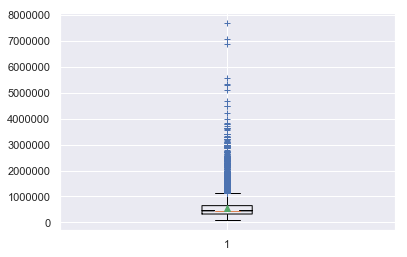

In [30]:
#create a box and whisker plot of home prices to see how the mean compares to median, check for outliers
plt.boxplot(df['price'],1, showmeans = True, sym = 'b+')

### Based on the percentile assessment and the box and whisker plot, the median price of homes falls within the 450,000 dollar price range which differs from the mean price of 540,088 dollars.  The plot shows that this may be due to some houses on the higher end of the dataset skewing the mean home price.

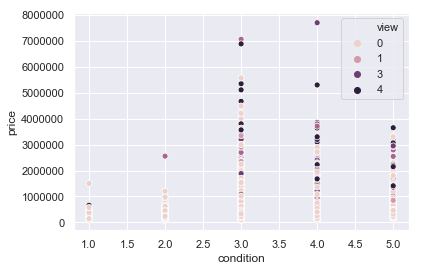

In [31]:
#take a look at relationship between the condition of a home and how many views it gets from prospective home buyers
sns.scatterplot(x = 'condition', y = 'price', data = df, hue = 'view')
plt.show()

In [32]:
#calculate the mean building condition to see how it compares to the scatterplot
print("mean building condition:", np.mean(df['condition']))

mean building condition: 3.4094295100171195


## The scatterplot above shows two interesting trends. The first trend is that the number of views of prospective home buyers is highest when the price of the home is the highest. The views appear equally distributed between 3, 4 and 5 building condition ratings, with 5 representing the best building condition.  This may indicate that higher priced homes with average building condition may have other attributes such as a good school system, surrounding neighborhood or short commute to work that are also important to the home buyer. The second trend shows high views amongst lower priced homes that are in good condition. The high views of low priced homes with great building condition makes sense since the home buyer is concerned with both the condition of the home and the cost-effectiveness.  

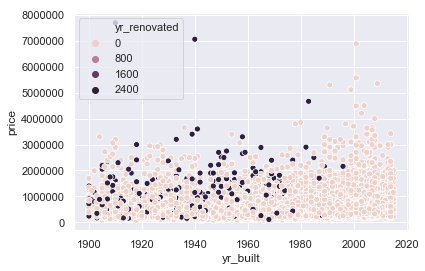

In [33]:
#take a look at the scatterplot between year built vs year renovated and price and notice if there are any trends
sns.scatterplot(x = 'yr_built', y = 'price', data =df, hue = 'yr_renovated')
plt.show()

### The interesting finding here is that homes built in the early 1900's in King County can be just as highly priced as those built in the 2000's.  The reason for this could be, "The number of homes on the market is at a low point, despite the big increase in population"(https://www.seattletimes.com/business/real-estate/why-are-seattle-area-home-prices-so-high/). Therefore, if there is a low supply of homes on the market, the older homes can still sell at a higher price. The plot also shows that the majority of home renovations are done on homes built before the 1980's.  Finally, the scatterplot shows that yr_renovated does not  show much of any correlation with home price even though yr_built does show a tiny correlation.  

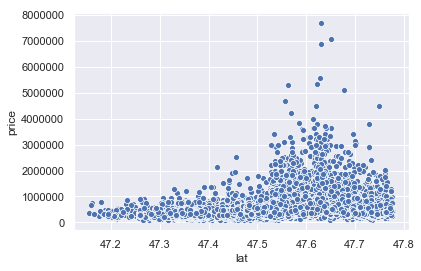

In [34]:
#take a look at trends between latitude and price and notice if there are any correlations
sns.scatterplot(x = 'lat',y = 'price', data = df)
plt.show()

### According to the scatter plot, the highest priced homes lie within the latitude of 47.6 which includes the cities of  Seattle, Medina and Bellevue, WA(home to Amazon, Bill Gates and T-mobile). The latitude of 47.7 includes the second largest group of highest priced homes and contains the cities of Kirkland and Redmond,WA(home to Google and Microsoft).  This agrees with King County house price trends in those areas. https://gismaps.kingcounty.gov/iMap/

In [35]:
#utilizing numpy mean, find means of bedrooms and bathrooms
#create a variable for the no of bathrooms to do further data visualizations
no_of_bathrooms = df[['bathrooms']]
no_of_bedrooms = df[['bedrooms']]
mean_no_bedrms = np.mean(no_of_bedrooms)
mean_no_bathrms = np.mean(no_of_bathrooms)
print('mean no of ', mean_no_bedrms)
print('mean no of ', mean_no_bathrms)

mean no of  bedrooms    3.370842
dtype: float64
mean no of  bathrooms    2.114757
dtype: float64


### Performing numpy stats shows us that the average number of bedrooms is approx 3, the average number of bathrooms is 2 .

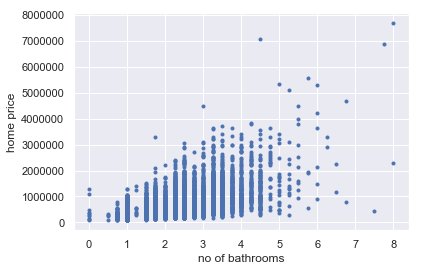

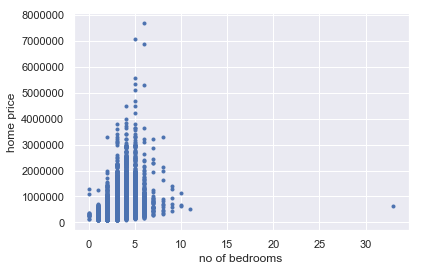

In [36]:
#Since the number of bathrooms was very highly correlated with price, 
#take a look at a scatterplot of no of bathrooms vs home price
_ = plt.plot(no_of_bathrooms, prices_homes, marker = '.', linestyle = 'none')
_ = plt.xlabel('no of bathrooms')
_ = plt.ylabel('home price')
plt.show()
_ = plt.plot(no_of_bedrooms, prices_homes, marker = '.', linestyle = 'none')
_ = plt.xlabel('no of bedrooms')
_ = plt.ylabel('home price')
plt.show()

### The scatterplot of bathrooms and home price shows a definite direct correlation between home price and the number of bathrooms. However, what's interesting is that after 3.5 bathrooms there are many data points within 4-5 bathrooms that are the same price range as 3.5 bathrooms so it appears the home prices level off a bit after 3.5 bathrooms.  The number of bedrooms is correlated with price up to about 5 bedrooms but after that does not seem as directly correlated with price.  

In [37]:
'''
Since histogram plots can suffer from thinning bias, take a look at the cumulative distribution function plot
in order to further analyze the distribution of data of bedrooms, bathrooms ,year and price.
'''
def ecdf(data):
    xaxis = np.sort(data)
    yaxis = np.arange(1,len(data) + 1)/ len(data)
    return xaxis, yaxis

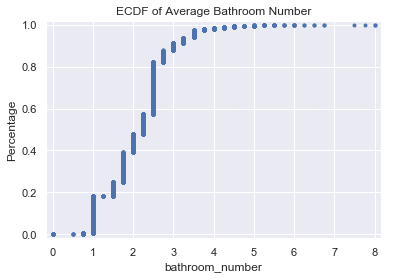

In [38]:
#compute ecdf for the number of bathrooms

x_bath, y_bath = ecdf(df['bathrooms'])
_ = plt.plot(x_bath, y_bath, marker = '.', linestyle = 'none')
_ = plt.title('ECDF of Average Bathroom Number')
_ = plt.xlabel('bathroom_number')
_ = plt.ylabel('Percentage')
_ = plt.margins(0.02)
plt.show()

### The cumulative distribution function shows that the 50% probability of number of bathrooms falls between 2 and 2.25 which makes sense since the calculated mean number of bathrooms in our dataset was 2.

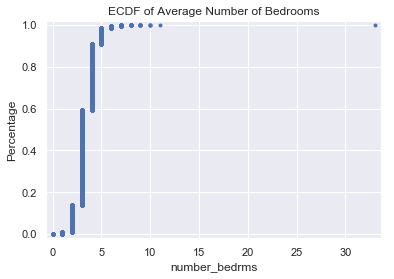

In [39]:
#plot more ECDF visualizations(no of bedrooms)
x_bed, y_bed = ecdf(df['bedrooms'])
_ = plt.plot(x_bed, y_bed, marker = '.', linestyle = 'none')
_ = plt.title('ECDF of Average Number of Bedrooms')
_ = plt.xlabel('number_bedrms')
_ = plt.ylabel('Percentage')
_ = plt.margins(0.02)
plt.show()

### In this ecdf visualization for the number of bedrooms, the 50% probability is seen around 3 which makes sense since it corresponds to our mean number of 3 bedrooms. Next, an ecdf plot will be utilized to see if there's any correlation between price and year in this dataset.

In [40]:
#create column of just the year only in order to plot ecdf
df['year'] = df['date'].apply(lambda row:row[:4])
df['year'].head()

0    2014
1    2014
2    2015
3    2014
4    2015
Name: year, dtype: object

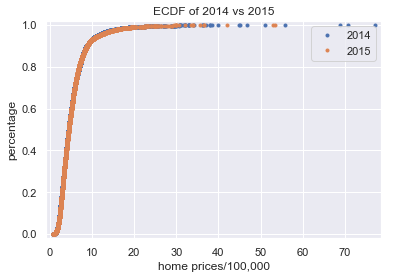

In [41]:
#define function for ecdf:
def plot_ecdf(data, title = "ECDF of 2014 vs 2015", xlabel = "home prices/100,000", ylabel = "percentage"):
    xaxis = np.sort(data)
    yaxis = np.arange(1,len(data) + 1)/ len(data)
    _ = plt.plot(xaxis, yaxis, marker = '.', linestyle = 'none')
    _ = plt.title(title)
    _ = plt.xlabel(xlabel)
    _ = plt.ylabel(ylabel)
    _ = plt.margins(0.02)

#create variable for year and plot ecdf for 2014 and 2015 to compare the average price percentage between the two years
years = df.year.unique()
df_simp = df['price'] * .00001
for year in years:
    plot_ecdf(df_simp[df.year == year])
plt.legend(labels=years)
plt.show()

### The ecdf plot of 2014 vs 2015 homes shows that the average home price was roughly the same in both consecutive years and thus that ['year'] is not highly correlated with price in this dataset.

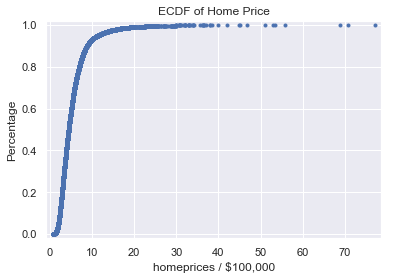

In [42]:
#plot the home prices on the ECDF plot 
x_pr, y_pr = ecdf(df['price'] * .00001)
_ = plt.plot(x_pr, y_pr, '.')
_ = plt.xlabel('homeprices / $100,000')
_ = plt.ylabel('Percentage')
_ = plt.title('ECDF of Home Price')
_ = plt.margins(0.02)
plt.show()

### Plotting the home prices on the ecdf plot shows us that the 50% probability of homes falls around the 500,000 dollar mark.  This seems to align with both the mean home price of 540,088 dollars and the median home price of 450,000 dollars. The ecdf visualizations also confirm that our data falls within a normal distribution for the most part,however, we will conduct hypothesis testing to decide if the higher priced homes are outliers and need to be removed from the dataset.

## Frequentist/Bootstrap Hypothesis Testing #1:
### null hypoth: diff of means between dataset building grade mean and bootstrap building grade mean = 0
### alt hypoth: diff of means between dataset building grade mean and bootstrap building grade mean != 0

In [43]:
#visualizations determined data was normally distributed but that mean home price may or may not be skewed
#sample size > 30, therefore observations are independent
#bootstrap testing will compare numpy mean(7.66) of building grade with bootstrap testing mean of building grade
from statsmodels.stats.weightstats import ztest
bs_sample = np.random.choice(df['grade'], size = 100)
bs_mean = np.mean(bs_sample)
bs_std = np.std(bs_sample)
print("boot strap mean and bootstrap standard deviation:", bs_mean,",", bs_std)
z, pval = ztest(bs_sample,df['grade'], alternative='two-sided')
print('zscore is:', round(z,2))
print('pvalue is:', round(pval,2))

boot strap mean and bootstrap standard deviation: 7.52 , 1.0628264204469138
zscore is: -1.16
pvalue is: 0.25


### The z score above corresponds to a p value of .65, which is greater than .05, and therefore we fail to reject the null hypothesis and conclude that there is no statistical difference between the difference of  means even when a random sample for the highly correlated feature, building grade, is chosen and compared to the actual building grade mean.

## Frequentist/Bootstrap Hypothesis Testing #2:
### Null hypoth: The difference of means of home price with 3 bedrooms and 2 bathrooms = 0  

### Alt hypoth: The difference of means of home price with 3 bedrooms and 2 bathrooms != 0

In [44]:
#take a look at home prices with 3 bedrooms
is_ave = df.bedrooms == 3
three_rms = df[is_ave]
print(len(three_rms), 'is number of three bedrm homes')
three_rms_price = three_rms['price']
#evaluate the mean of home prices with 3 bedrooms
print("three bedrm mean home price is:", round(np.mean(three_rms_price)))

9824 is number of three bedrm homes
three bedrm mean home price is: 466232


In [45]:
#calculate the mean home price with 2 bathrooms
is_ave_bath = df.bathrooms == 2
two_bath = df[is_ave_bath]
two_bath_price = two_bath['price']
print(len(two_bath), 'is no of 2 bathrm homes')
print("two bathrm mean home price is:", round(np.mean(two_bath_price)))

1930 is no of 2 bathrm homes
two bathrm mean home price is: 457890


### These findings suggest that the mean number of bedrooms(3) is associated with a mean home price of 466,232 dollars and the mean number of bathrooms(2) is associated with a mean home price of 457,890 dollars.  Although the 3 bedroom mean home price is more closely aligned with the overall mean home price of 540,088 dollars, the 2 bathroom mean home price is more closely aligned with the median home price of 450,000 dollars. This discrepancy may be due to the fact that there is a larger sample size(9824) of 3 bedrooms than that of two bathrooms(1930) or may again be due to the fact that the mean home price of 540,088 is being skewed by  higher priced homes. If we, instead, compare our stats against the median home price, then the two bathroom homes appears more correlated which makes sense since correlation testing indicated that the number of bathrooms was more correlated with home price than the number of bedrooms.

In [46]:
#compare the two bathroom mean home price with the three bedroom mean home price using hypothesis testing
diff_of_means = np.mean(three_rms_price) - np.mean(two_bath_price)
print("the diff of means is:", round(diff_of_means,2))

the diff of means is: 8342.36


In [47]:
#import stats package to determine p value and to recheck z score above.
z, pval = ztest(three_rms_price,two_bath_price, alternative='two-sided')
print('zscore is:', round(z,2))
print('pvalue is:', round(pval,2))

zscore is: 1.32
pvalue is: 0.19


### The p-value of .19 indicates that we can fail to reject the null hypothesis that there is a statistical difference between the mean home price of two bathrooms and the mean home price of three bathrooms.This is exciting since it helps us in our home price prediction analysis.  Last we will compare the mean home price using bootstrapping method against the actual mean home price. 

## Frequentist/Bootstrap Hypothesis Testing #3:
### null hypoth: diff of means between dataset home price mean and bootstrap home price mean = 0
### alt hypoth: diff of means between dataset home price mean and bootstrap home price mean!= 0

In [48]:
#compare the mean home price of the actual dataset with mean home price of the bootstrap sample
print("Mean home price is:", home_mean)
home_std = (np.std(df['price']))
print("Home price standard deviation is:", home_std)
bs_sample = np.random.choice(df['price'], size = 2000)
bs_mean = np.mean(bs_sample)
bs_std = np.std(bs_sample)
print("Bootstrap mean and Bootstrap std dev is:", bs_mean,',',bs_std)

Mean home price is: 540088.1417665294
Home price standard deviation is: 367118.7031813722
Bootstrap mean and Bootstrap std dev is: 537664.093 , 377496.55947642407


In [49]:
diff_of_means = home_mean - bs_mean
print("difference of means is:", diff_of_means)
sd = (home_std)**2/21613 + (bs_std)**2/2000
twosamp_std = sd ** 0.5
print('twosamp_std: ', twosamp_std)

difference of means is: 2424.0487665294204
twosamp_std:  8802.710340832647


In [50]:
zscre = (diff_of_means - 0)/ (twosamp_std)
print("z-score: ", zscre)
marg_of_err = (1.96) * (twosamp_std)
print("margin of error: ", marg_of_err)
conf_int = (diff_of_means + marg_of_err), (diff_of_means - marg_of_err)
print("confidence interval: ", conf_int)

z-score:  0.27537527337292006
margin of error:  17253.31226803199
confidence interval:  (19677.36103456141, -14829.26350150257)


In [51]:
from statsmodels.stats.weightstats import ztest
z, pval = ztest(df['price'],bs_sample, alternative='two-sided')
print('zscore is:', round(z,2))
print('pvalue is:', round(pval,2))

zscore is: 0.28
pvalue is: 0.78


### Based on the p-value of >.05, we can fail to reject the null hypothesis that there is a statistical difference between the mean of our bootstrap sample and the mean of our housing price data set.  

### Within a margin of error of 16,739 dollars, we can be 95% certain that the confidence interval range above contains our true mean.  The high standard deviation however in both the bootstrap data set as well as the actual dataset is an indication that there is a high degree of variability of some data points from the mean.  This might be due to the few houses that are on the higher end of the dataset skewing the mean.  This is an important finding from hypothesis testing as it indicates that, as the dataset stands, the median may be a more reliable measurement of central tendency.  It also indicates, that these outliers,or higher priced homes, may need to be removed from the dataset. However, before removing these values from the dataset, we will utilize logarithmic function on home prices to see if that normalizes the home prices and decreases the spread.  

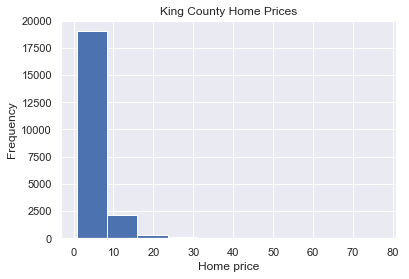

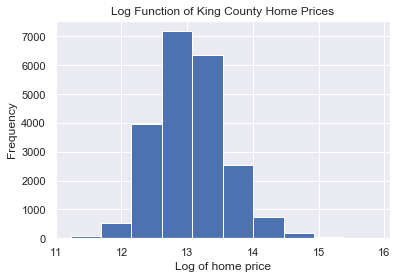

In [52]:
#plot out log of price in histogram to see if it improves the home price distribution(compare againt orig home price histogram)
l_price = np.log(df['price'])
plt.hist(df['price']*.00001)
plt.title("King County Home Prices")
plt.xlabel("Home price")
plt.ylabel("Frequency")
plt.show()
plt.hist(l_price)
plt.title("Log Function of King County Home Prices")
plt.xlabel("Log of home price")
plt.ylabel("Frequency")
plt.show()

### The histogram above shows a considerable improvement in distribution by taking the log of home prices

In [53]:
#do hypothesis testing again on log of price data and re-evaluate z-score, std dev and mean to insure improvement
l_home_mean = np.mean(l_price)
print("mean log home price is:", l_home_mean)
l_home_std = (np.std(l_price))
print("log home price std is:", l_home_std)
l_bs_sample = np.random.choice(l_price, size = 2000)
l_bs_mean = np.mean(l_bs_sample)
l_bs_std = np.std(l_bs_sample)
print('bootstrap mean is:', l_bs_mean)
print('bootstrap std is:', l_bs_std)

mean log home price is: 13.047816917155423
log home price std is: 0.5266723344538438
bootstrap mean is: 13.0465818987492
bootstrap std is: 0.5244510546588237


### This shows that by taking the log function of home prices, the new standard deviation measurement is no longer creating a large spread from the mean.  

In [54]:
z, pval = ztest(l_price,l_bs_sample, alternative='two-sided')
print('zscore is:', round(z,2))
print('pvalue is:', round(pval,2))

zscore is: 0.1
pvalue is: 0.92


### The p value greater than .05 indicates that there is not a statistical difference between the log of the actual home price mean and the log of the bootstrap home price mean.

In [55]:
#compute percentiles again for the prices of homes but this time utilizing log f(x)
#compare median home price with mean home price
percentiles = np.array([2.5, 25, 50, 75, 97.5])
l_homes_percent = np.percentile(l_price,percentiles)
print("log home percentiles for 2.5%, 25%, 50%, 75% and,97.5% is:", l_homes_percent)
print("mean log home price is:", round(l_home_mean,2))
l_home_med = np.log(home_med)
print('median home price(50th percentile) is:', round(l_home_med, 2))

log home percentiles for 2.5%, 25%, 50%, 75% and,97.5% is: [12.1281111  12.68215153 13.01700286 13.3770056  14.21092533]
mean log home price is: 13.05
median home price(50th percentile) is: 13.02


### Calculating the log of mean home price(13.05) and the log of median home price(13.02), shows an improved central tendency by taking the logarithmic function of home price. 

{'whiskers': [<matplotlib.lines.Line2D at 0x28713b60e80>,
 'caps': [<matplotlib.lines.Line2D at 0x28713b40860>,
 'boxes': [<matplotlib.lines.Line2D at 0x28713b60cf8>],
 'medians': [<matplotlib.lines.Line2D at 0x28713b40f60>],
 'fliers': [],
 'means': [<matplotlib.lines.Line2D at 0x28713b7a320>]}

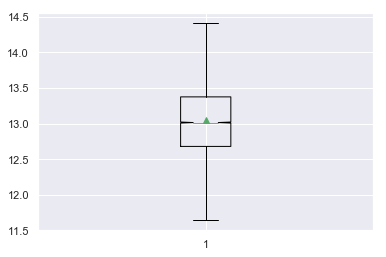

In [56]:
# take a look at the box and whisker plot with log of price and showmeans=True
# see if data is distributed well and if the mean marker lies close to the median line
plt.boxplot(l_price, 1, showmeans = True, sym = '')

### The box and whisker plot also shows an improved distribution with taking the log function of home prices. In conclusion, we will not remove the higher priced homes from the dataset but rather utilize the logarithmic function on home price values.

In [57]:
#create new column for log of prices 
df['log_price'] = l_price
df['log_price'].head()

0    12.309982
1    13.195614
2    12.100712
3    13.311329
4    13.142166
Name: log_price, dtype: float64

## Next, we will begin supervised machine learning since all data in dataset is labeled. We will use a regression machine learning algorithm, since the response being predicted, price of home, is ordered and continuous.

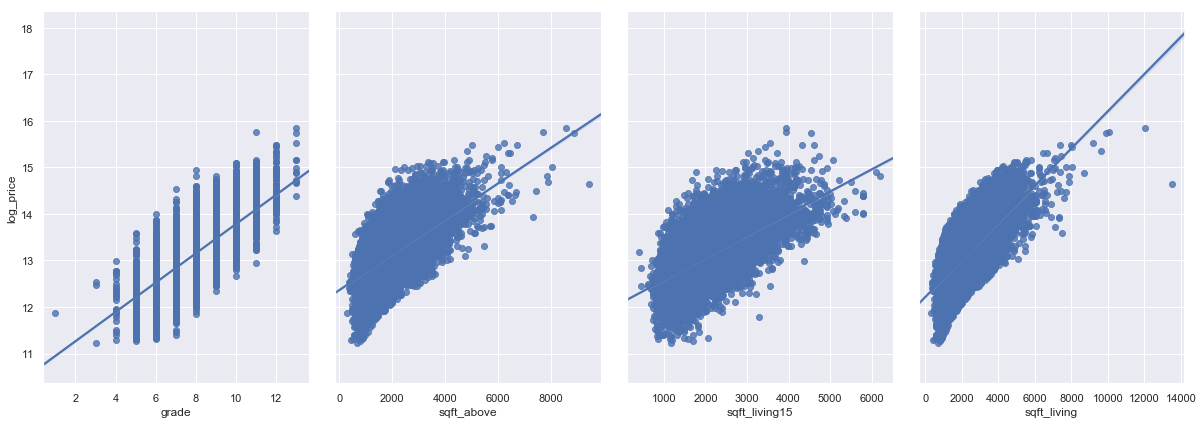

In [58]:
#fit linear regression line to the scatter plot and take a look at which features to choose for the linear regression model
sns.pairplot(df, x_vars = ['grade', 'sqft_above', 'sqft_living15','sqft_living'], y_vars = ['log_price'], height=6, aspect=0.7, kind='reg')

In [59]:
#import packages to begin regression testing
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import cross_val_score

In [60]:
#create a data array utilizing top four features that had strong correlation with price based on previous stats testing
x_cols = ['grade', 'sqft_above', 'sqft_living','sqft_living15']
X = df[x_cols]
print(X.head())
type(X)

   grade  sqft_above  sqft_living  sqft_living15
0      7        1180         1180           1340
1      7        2170         2570           1690
2      6         770          770           2720
3      7        1050         1960           1360
4      8        1680         1680           1800


pandas.core.frame.DataFrame

In [61]:
#assign the predictor(target) variable
y = df['log_price']
print(y.head())
type(y)

0    12.309982
1    13.195614
2    12.100712
3    13.311329
4    13.142166
Name: log_price, dtype: float64


pandas.core.series.Series

In [62]:
#create a linear regression model for features chosen(grade,bathrooms,sqft_living and bedrooms) vs response(price)
#make sure both are numeric, same shape and convert both to numpy arrays
from sklearn.linear_model import LinearRegression
linreg = linear_model.LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size = 0.7,random_state=42)
linreg.fit(X_train,y_train)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(15129, 4) (6484, 4) (15129,) (6484,)


In [63]:
#calculate the coefficients
linreg.coef_
#create a prediction model that closely predicts y_test and take the mean squared error
y_pred = linreg.predict(X_test)
np.mean((y_pred - y_test) **2)

0.12253644683787945

In [64]:
#now import sklearn package and compare mean squared error calculated manually vs calculated with sklearn 
from sklearn.metrics import mean_squared_error
mse = np.mean((y_pred - y_test) **2)
mse_r = mse ** (1/2)
print("root mean square error is:", mse_r)
print("mean square error is:", mean_squared_error(y_test, y_pred))
r2_score = linreg. score(X,y)
print("r2 score is:", r2_score)

root mean square error is: 0.35005206303902775
mean square error is: 0.1225364468378786
r2 score is: 0.5697357160331856


## Since R^2 of .56 is low here utilize OLS to determine if there are better features to select for the model.

In [65]:
# Import regression modules and utilize ordinary least squares(OLS) to look at rsquared, AIC/BIC and pvalue
import statsmodels.api as sm
from statsmodels.formula.api import ols
m = ols('log_price ~ grade',df).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.495
Model:                            OLS   Adj. R-squared:                  0.495
Method:                 Least Squares   F-statistic:                 2.119e+04
Date:                Thu, 06 Jun 2019   Prob (F-statistic):               0.00
Time:                        14:44:13   Log-Likelihood:                -9424.6
No. Observations:               21613   AIC:                         1.885e+04
Df Residuals:                   21611   BIC:                         1.887e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.6338      0.017    633.827      0.0

### Utilizing OLS, the AIC/BIC values were found to be similar for all the features with the lowest being sqft_living, sqft_living15, sqft_above, bathrooms and grade which agrees with all our previous analyses of those features being strongly correlated with price.  Looking at the R^2 for all the individual features with price indicates that the following features have near zero R^2 value( long, zipcode, year and yr_renovated). Therefore, these features will be left out of the machine learning model.  The highest R^2 when comparing individual features with price are(grade, sqft_living, sqft_above and sqft_living15).  

[ 1.35972491e-01 -3.93824525e-05  2.03109109e-04  7.76914670e-05
  2.37650598e-02  1.47632295e+00  9.96452816e-02]
0.07639367450422758
root mean square error is: 0.27639405656458604
mean square error is: 0.07639367450422756
r2 score is: 0.7287724785721592


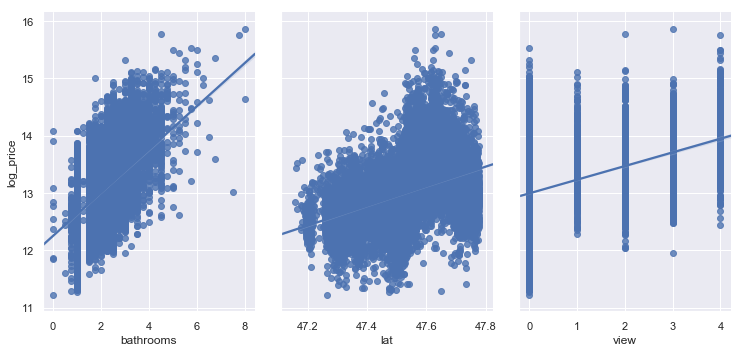

In [66]:
#utilize the top seven features that individually have the highest r^2 and see how this changes the prediction model
sns.pairplot(df, x_vars = ['bathrooms','lat','view'], y_vars = ['log_price'], height=5, aspect=0.7, kind='reg')
X1 = df[['grade', 'sqft_above', 'sqft_living','sqft_living15','bathrooms','lat','view']]
X_train, X_test, y_train, y_test = train_test_split(X1,y,train_size = 0.6,random_state=42)
linreg.fit(X_train,y_train)
print(linreg.coef_)
y_pred = linreg.predict(X_test)
print(np.mean((y_pred - y_test) **2))
mse = np.mean((y_pred - y_test) **2)
mse_r = mse ** (1/2)
print("root mean square error is:", mse_r)
print("mean square error is:", mean_squared_error(y_test, y_pred))
r2_score = linreg. score(X1,y)
print("r2 score is:", r2_score)

### Based on this, a combination of adding in more feaures and utilizing high R^2 features improved the model further. We will add in more high R^2/low AIC/BIC features to see if there is further improvement in the model.

[1.36615061e-01 1.25891086e-04 3.95507880e-05 7.48571028e-05
 1.42367754e-02 1.36503848e-03 8.63403001e-05 8.24220836e-02
 1.48598537e+00 2.87103905e-07 1.41407276e-02 4.09447141e-01]
0.07693933133732991
root mean square error is: 0.27737939962681063
mean square error is: 0.07693933133732979
r2 score is: 0.7329201086495442


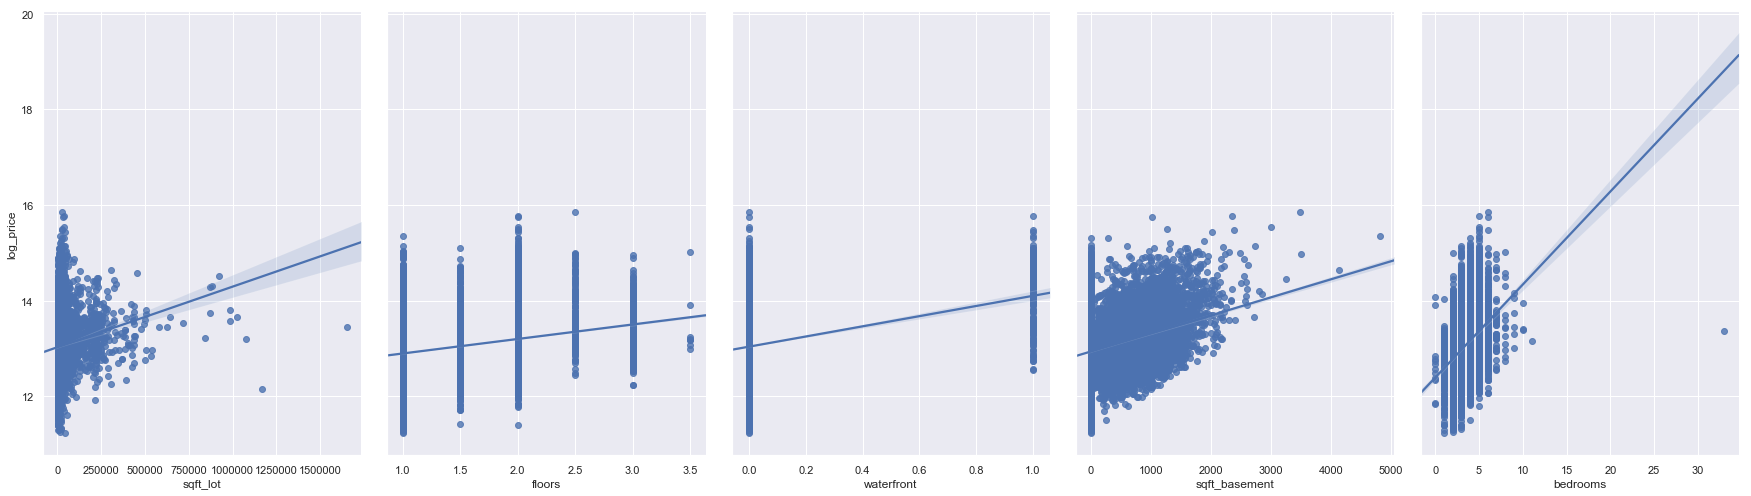

In [67]:
# add in bedrooms, sqft_basement, view, lat, waterfront, sqft_lot,and floors to previous features for a total of 12 features
sns.pairplot(df, x_vars = ['sqft_lot','floors','waterfront','sqft_basement','bedrooms'], y_vars = ['log_price'], height=7, aspect=0.7, kind='reg')
X2 = df[['grade', 'sqft_living','sqft_above','sqft_living15','bathrooms','bedrooms','sqft_basement','view','lat','sqft_lot', 'floors', 'waterfront']]
X_train, X_test, y_train, y_test = train_test_split(X2,y,train_size = 0.7,random_state=42)
linreg.fit(X_train,y_train)
print(linreg.coef_)
y_pred = linreg.predict(X_test)
print(np.mean((y_pred - y_test) **2))
mse = np.mean((y_pred - y_test) **2)
mse_r = mse ** (1/2)
print("root mean square error is:", mse_r)
print("mean square error is:", mean_squared_error(y_test, y_pred))
r2_score = linreg. score(X2,y)
print("r2 score is:", r2_score)

### Adding in more high R^2/low AIC/BIC features definitely improved the model.  We will compare this result with the sklearn feature selection method and see if that further improves the model. 

In [68]:
x_colms = ['grade','bedrooms','year', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15','sqft_lot15']
X5 = df[x_colms]

In [69]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
ran = RandomForestRegressor(n_estimators=100)
sel = SelectFromModel(ran, threshold=0.005)
sel.fit(X5,y)

SelectFromModel(estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
        max_features=None, norm_order=1, prefit=False, threshold=0.005)

In [70]:
sel.get_support(indices=True)
selected_feat=X5.columns[(sel.get_support())]
len(selected_feat)

13

In [71]:
print(selected_feat)

Index(['grade', 'bathrooms', 'sqft_living', 'sqft_lot', 'waterfront', 'view',
       'sqft_above', 'yr_built', 'zipcode', 'lat', 'long', 'sqft_living15',
       'sqft_lot15'],
      dtype='object')


### The sklearn feature selection method indicates eliminating 5 features(bedrooms, year, floors, sqft_basement, and yr_renovated) from the total 19 features.  Test if these 14 features improve the model.

[ 1.65785861e-01  8.88804744e-02  1.18976348e-04  3.79534570e-07
  3.92218351e-01  6.66536336e-02  2.31277408e-05 -3.32289014e-03
 -5.62708672e-04  1.42046779e+00 -1.49805032e-01  8.34318215e-05
 -1.40671831e-07  4.96325795e-02]
0.0666421036846733
root mean square error is: 0.2581513193548956
mean square error is: 0.06664210368467326
r2 score is: 0.7661553338028607


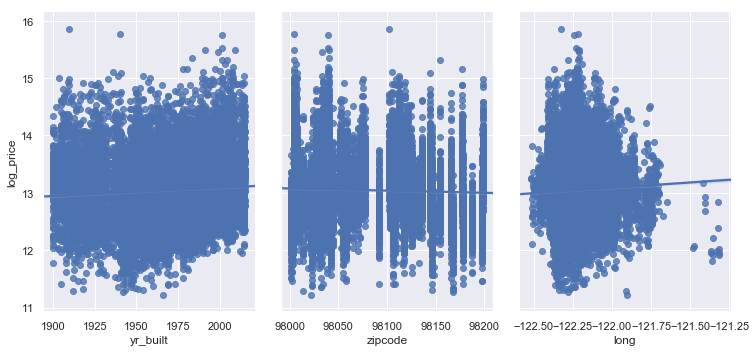

In [72]:
#choose features based on above feature selection method
#add in zipcode and long,
sns.pairplot(df, x_vars = ['yr_built', 'zipcode','long'], y_vars = ['log_price'], height=5, aspect=0.7, kind='reg')
X3 = df[['grade','bathrooms', 'sqft_living','sqft_lot', 'waterfront', 'view', 'sqft_above', 'yr_built', 'zipcode',
'lat', 'long', 'sqft_living15', 'sqft_lot15','condition']]
X_train, X_test, y_train, y_test = train_test_split(X3,y,train_size = 0.7,random_state=42)
linreg.fit(X_train,y_train)
print(linreg.coef_)
y_pred = linreg.predict(X_test)
print(np.mean((y_pred - y_test) **2))
mse = np.mean((y_pred - y_test) **2)
mse_r = mse ** (1/2)
print("root mean square error is:", mse_r)
print("mean square error is:", mean_squared_error(y_test, y_pred))
r2_score = linreg. score(X3,y)
print("r2 score is:", r2_score)

### Adding even more features, improved the model even further.  Since we want to to eliminate bias and over-fitting, we will combine features from the different feature selection methods and see if that improves the model further. The most interesting discovery in using sklearn feaure selection method was that all the location-related features were important to the housing price prediction model which means the ol' real estate adage about location may be correct! Another interesting finding was that year, yr_renovated, bedrooms, floors and sqft_basement were eliminated via sklearn feature selection.  Year, yr_renovated, floors and bedrooms agreed with our previous visulaizations and stats of not being the best predictors of home price.  In our earlier visualizations, however, it was unclear whether sqft_basement was correlated with price or whether it was more related to other factors such as larger home size.  Therefore, the sklearn feature selection removal of sqft_basement is an important finding. It indicates not only are there not a lot of homes in King County with a basement, but also that sqft_basement is not a significant home price predictor in King County.  

In [73]:
# combine different feature selection methods to select 15 features to improve model further 
#features removed:year and yr_renovated(from sklearn feat sel), sqft_lot15 and sqft_above(from R^2/AIC/BIC stats)
X4 = df[['grade','bathrooms','bedrooms', 'sqft_living','sqft_lot',
       'floors','waterfront', 'view','condition',
       'yr_built','zipcode','sqft_basement',
       'lat','long' ,'sqft_living15']]
X_train, X_test, y_train, y_test = train_test_split(X4,y,train_size = 0.7,random_state=42)
linreg.fit(X_train,y_train)
print(linreg.coef_)
y_pred = linreg.predict(X_test)
mse = np.mean((y_pred - y_test) **2)
mse_r = mse ** (1/2)
print("mean sq error is:", mean_squared_error(y_test, y_pred))
print("root mean square error is:", mse_r)
r2_score = linreg. score(X4,y)
print("r2 score is:", r2_score)

[ 1.59657307e-01  7.40385455e-02 -1.18311078e-02  1.38001582e-04
  3.33452604e-07  7.66911479e-02  3.82934353e-01  6.41007156e-02
  5.37505458e-02 -3.69092098e-03 -6.38354067e-04  1.84685544e-05
  1.39761075e+00 -1.26476895e-01  9.15522457e-05]
mean sq error is: 0.06564339298950503
root mean square error is: 0.2562096660735204
r2 score is: 0.7695807969673532


In [74]:
#take a look at how model is predicting prices, see if its similar#make scatterplot of y_test vs y_pred
print(y_pred[0])
print(y_test[0])

12.966566808640522
12.309982108920686


## After looking at several different feature selection methods and comparing R^2, AIC/BIC, pvalue, coefficients, RMSE and MSE, it seems that the model with 15 features is giving the best prediction model with the highest linear regression scoring of r^2 = 77%.  The features that were removed were: year and yr_renovated(from sklearn feature selection), sqft_lot15 and sqft_above(from R^2/AIC/BIC stats).  We will take a look at a couple more algorithms to compare the different features but also to see which algorithm is the best predictor of home prices. 

In [75]:
#utilize the random forest regressor model
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0)
rand_reg = RandomForestRegressor(n_estimators=100,random_state=0)
rand_reg.fit(X_train,y_train)
print("accuracy on the training subset:{:.3f}".format(rand_reg.score(X_train,y_train)))
print("accuracy on the test subset:{:.3f}".format(rand_reg.score(X_test,y_test)))

accuracy on the training subset:0.911
accuracy on the test subset:0.517


In [76]:
#compare same algorithm on different features
X_train, X_test, y_train, y_test = train_test_split(X1,y,random_state=0)
rand_reg = RandomForestRegressor(n_estimators=100,random_state=0)
rand_reg.fit(X_train,y_train)
print("accuracy on the training subset:{:.3f}".format(rand_reg.score(X_train,y_train)))
print("accuracy on the test subset:{:.3f}".format(rand_reg.score(X_test,y_test)))

accuracy on the training subset:0.974
accuracy on the test subset:0.830


In [77]:
#different features tested
X_train, X_test, y_train, y_test = train_test_split(X2,y,random_state=0)
rand_reg = RandomForestRegressor(n_estimators=100,random_state=0)
rand_reg.fit(X_train,y_train)
print("accuracy on the training subset:{:.3f}".format(rand_reg.score(X_train,y_train)))
print("accuracy on the test subset:{:.3f}".format(rand_reg.score(X_test,y_test)))

accuracy on the training subset:0.977
accuracy on the test subset:0.850


In [87]:
#different features tested
X_train, X_test, y_train, y_test = train_test_split(X3,y,random_state=0)
rand_reg = RandomForestRegressor(n_estimators=100,random_state=0)
rand_reg.fit(X_train,y_train)
print("accuracy on the training subset:{:.4f}".format(rand_reg.score(X_train,y_train)))
print("accuracy on the test subset:{:.4f}".format(rand_reg.score(X_test,y_test)))

accuracy on the training subset:0.9815
accuracy on the test subset:0.8890


In [88]:
#different features tested 
X_train, X_test, y_train, y_test = train_test_split(X4,y,random_state=0)
rand_reg = RandomForestRegressor(n_estimators=100,random_state=0)
rand_reg.fit(X_train,y_train)
print("accuracy on the training subset:{:.4f}".format(rand_reg.score(X_train,y_train)))
print("accuracy on the test subset:{:.4f}".format(rand_reg.score(X_test,y_test)))

accuracy on the training subset:0.9816
accuracy on the test subset:0.8890


### Similar to the linear regression model, the 15 features combining stats analysis and sklearn feature selection gives the best home price prediction on the Random Forest Regressor model.  

In [85]:
#do same thing but with the Gradient Boosting Regressor Algorithm
from sklearn.ensemble import GradientBoostingRegressor
X_train,X_test,y_train,y_test = train_test_split(X3,y,random_state=0)
est = GradientBoostingRegressor(n_estimators=500,max_depth=4,learning_rate=0.1,min_samples_leaf=3,random_state=0)
est.fit(X_train,y_train)
print("accuracy on the training subset:{:.4f}".format(est.score(X_train,y_train)))
print("accuracy on the test subset:{:.4f}".format(est.score(X_test,y_test)))

accuracy on the training subset:0.9383
accuracy on the test subset:0.9023


In [86]:
#compare model with all 15 features utilized
from sklearn.ensemble import GradientBoostingRegressor
X_train,X_test,y_train,y_test = train_test_split(X4,y,random_state=0)
est = GradientBoostingRegressor(n_estimators=500,max_depth=4,learning_rate=0.1,min_samples_leaf=3,random_state=0)
est.fit(X_train,y_train)
print("accuracy on the training subset:{:.4f}".format(est.score(X_train,y_train)))
print("accuracy on the test subset:{:.4f}".format(est.score(X_test,y_test)))

accuracy on the training subset:0.9379
accuracy on the test subset:0.9024


### The gradient boosting regressor model,also shows that utilizing the 15 features chosen from stats analysis and sklearn feature selection gives the best home price prediction.

Text(0, 0.5, 'Original Price')

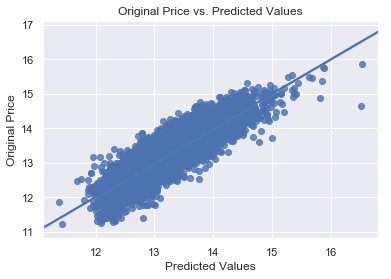

In [82]:
sns.regplot(y=df['log_price'], x=linreg.predict(X4),fit_reg = True)
plt.title('Original Price vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Original Price')

## Original Price vs Predicted Price plot shows that this model is doing a good job at predicting King County Home prices.

In [83]:
#perform Ridge regularization testing on X4 model
X_train,X_test,y_train,y_test = train_test_split(X4,y,random_state=42)
ridge_regr = linear_model.Ridge(alpha = .0001, normalize=True)
ridge_model = ridge_regr.fit(X_train,y_train)
print("ridge model score is:", ridge_model.score(X_test,y_test))

ridge model score is: 0.7717917744016588


In [84]:
#perform lasso regularization testing on X4 model
X_train,X_test,y_train,y_test = train_test_split(X4,y,random_state=42)
lasso_regr = linear_model.Lasso(alpha = .00001, normalize=True)
lasso_model = lasso_regr.fit(X_train,y_train)
print("lasso model score is:", lasso_model.score(X_test,y_test))

lasso model score is: 0.7715372006991247


## In comparing the linear regression model, random forest regressor and gradient boosting regressor, the gradient boosting regressor is the classifier that gave us the highest score of 93% and 90% respectively on the training and test model and a 77% score on both the Ridge and Lasso Regression testing. A total of 15 features were utilized from our original dataset of 20 features.  Even though it was known that  sqft_living and building grade were important features to the housing price prediction model, the following features did not have as much impact on the housing price prediction model and were eliminated(year, yr_renovated, sqft_above and sqft_lot15).  Finally, even though sqft_basement and bedrooms were kept as features, in the final model, they were also not found to be the highest predictors of home price in  King County.  The location based features (zipcode, lat, long) had a very large impact on the machine learning models as removing them significantly reduced the model's ability to predict home prices ("There are three things that matter in property: Location,Location,Location!"-quote by Harold Samuel).